
**Lab 3/Midterm 1: FastSLAM**

In this lab, you will implement a FastSLAM for 
making a map and localisation of a 2D Rat.

The modules for Rat, Map and other basic methods
and data structures for particles, and their updates
has been provided.

You need to code up the following three functions: <br>
a) [20] occUpdate: the function to update the occupancy map <br>
b) [10] sampleImportanceResample: the particle resampling portion <br>
c) [5] estPoseMap : estimate the final pose and map <br>

Your submission is the final code and a short discussion
paper which answers the following questions <br>
a) [10] your equations for likelihood calculations <br>
b) [30] your estimated map and pose after 400 time steps <br>
c) [10] Discussions on your results: its limitations and how you could potentially  improve it further. <br>
d) [10] Any other improvements will get bonus marks <br>


This open book. You may discuss/consult, but I expect you to do
your own work.

***Notation***

$m_{ij}$:  ${ij}^{th}$ binary map variable in a 2D grid. <br>
$v_{ij}$: ${ij}^{th}$ value variable of the map feature.<br>
$m = ((m_{11},v_{11}, (m_{12},v_{12}, .... (m_{NN},v_{NN}))$ is the grid of map values. <br>

$x_t$: Location of the robot at time step t). <br>
$x_{0:t}$: Location at time steps 0,1,..,t. (Trajectory) <br>
$z_{1:t}$: Measurements at time steps 1,..,t. <br>Here $z_i = (r_i, \theta_i, v_i)$ : range, direction and value (relative to robot's location) <br>
$u_{1:t}$: control inputs at time steps 1,..,t. <br>
$p_{tm}$: Probability of a true measurement <br>
$p_{fp}$: Probability of a false positive (erroneous measurement leading to a range measurement which is in a wrong location)<br>
$p_{fn}$: Probability of a false negative (erroneous measurement with range measurement not returning a value, i.e. says out of range)<br>
Note: $p_{tm}+p_{fp}+p_{fn} = 1$

***Bayesian update*** <br>
(1) <br>
$$
P(x_{0:t},m|z_{1:t}, u_{1:t}) = P(x_{0:t}|z_{1:t}, u_{1:t}) * P(m|x_{0:t},z_{1:t}, u_{1:t})
$$

We will look at each term separately:<br>
*For location:* <br>
(2) <br>

$$
P(x_{0:t}|z_{1:t},u_{1:t}) = P(x_t|x_{0:t-1},z_{1:t},u_{1:t})*P(x_{0:t-1}|z_{1:t},u_{1:t})
= P(x_t|x_{0:t-1},z_{1:t},u_{1:t})*P(x_{0:t-1}|z_{1:t-1},u_{1:t-1})
$$
A recursion as trajectory up to time t-1, doesnt depend on future control and measurement at $u_t$ and $z_t$.

For the first term in (2), assuming Markovian property we can write: <br>
(3)<br>
$$
P(x_t|x_{0:t-1},z_{1:t},u_{1:t}) = P(x_t|x_{t-1},z_{1:t},u_t) = P(z_t|x_t,u_t)*P(x_t|x_{t-1},u_t)* \frac{1}{P(z_t|z_{1:t-1},u_{1:t})}
$$

Putting these together, we can write the bayesian posterior of location as proportional to the product of measurement likelihood, motion model and prior as : <br>
(4) <br>
$$
P(x_{0:t}|z_{1:t},u_{1:t}) ∝ P(z_t|x_t,u_t)*P(x_t|x_{t-1},u_t)* P(x_{0:t-1}|z_{1:t-1},u_{1:t-1})
$$

*For Map:*<br>
Given a trajectory $x_{0:t}$, the map probabilities for the grid are independent of each other. There fore: <br>
(5)  <br>
$$
P(m|z_{1:t},x_{0:t},u_{0:t}) = \prod_{ij} P((m_{ij},v_{ij})|z_{1:t},x_{0:t},u_{0:t})
$$

For each map grid entry:<br>
(6) <br>
$$
P((m_{ij},v_{ij})|x_{0:t},z_{1:t},u_{1:t}) = P(m_{ij}|x_{0:t},z_{1:t},u_{1:t}) *P(v_{ij}|m_{ij},x_{0:t},z_{1:t},u_{1:t})
$$

Looking at the first term: <br>
(7) <br>
$$
P(m_{ij}|x_{0:t},z_{1:t}, u_{1:t}) = P(m_{ij}|z_t,z_{1:t-1},x_{0:t}, u_{1:t}) = P(z_t|m_{ij},z_{1:t-1},x_{0:t},u_{1:t})*P(m_{ij}|z_{1:t-1},x_{0:t},u_{1:t})*\frac{1}{P(z_t|z_{1:t-1},x_{0:t},u_{1:t})}
$$
The second term above is the prior from t-1 (as the measurements are only till t-1).<br>
The measurement at time t depends only on current state and map, so: <br>
(8) <br>
$$
P(z_t|m_{ij},x_{0:t},u_{1:t}) = P(z_t|m_{ij}, x_t) = P(m_{ij}|z_t,x_t)*\frac{P(z_t|x_t)}{P(m_{ij}|x_t)}
$$

Since $m_{ij}$ is binary, its complement's probability can be written as : <br>
(9) <br>
$$
P(!m_{ij}|z_{1:t},x_{0:t},u_{1:t}) = P(!m_{ij}|z_t,x_t)* \frac {P(!m_{ij}|z_{1:t-1},x_{0:t-1},u_{1:t-1})}{P(!m_{ij}|x_t)*P(z_t|z_{1:t-1},x_{0:t},u_{1:t})} * P(z_t|x_t)
$$

Note that since $m_{ij}$ is binary variable, <br>
(10) <br>
$$P(!m_{ij}) = 1-P(m_{ij})$$

Writing the binary variable probabilities as odds <br>
(11)<br>
 $$
 o_{ij}(t) = \frac{P(m_{ij}|z_{1:t},x_{0:t})}{{1-P(m_{ij}|z_{1:t},x_{0:t})}}$$
We have the following bayesian recursion for posterior of the odds, given the prior odds as: <br>
(12) <br>
$$
o_{ij}(t) = \frac{P(z_t|m_{ij},x_t)}{P(z_t|!m_{ij},x_t)} * \frac{1}{o_{ij}(0)}
$$

Then $p(z_t|m_{ij})$ is given by this table: <br>
\begin{array} {|c|c|c|}
\hline
m_{ij} & z_t=0 & z_t=1 \\
\hline
0 & p_{tm} & p_{fp} \\
\hline
1 & p_{fn} & p_{tm} \\
\hline
\end{array}


***Calculating Map Likelihood*** 

Let $z_t = \{(r_t, \theta_t, v)\}$ correspond to a measurement of the scan along the set of directions $\{\theta_t\}$ w.r.t the robot. Let $k$ be the equivalent index of the map cell, into which $r_t$ falls in. Let ${ij_0, ij_1, ...ij_k, ij_{k+1}, ij_{k+l}}$ be the indices of the map cells in the path of the beam and let $r_t$ correspond to cell with index $ij_k$.

To keep the notation simple, we will drop $ij$ in the description below.

Lets assume that the measurement noise is gaussian with mean 0 and deviation $\sigma$.
If the grid is of size $rStep$, and we restrict the support from $+-3\sigma$, this corresponds to looking at cells at $+-l$ with $l=3\sigma/rStep$ away from the the cell with hit $ij_k$ in both dimensions.

So let $p(k)$ be the probability of getting a hit in cell $k$ Which can happen from any neighbouring  cell $l$. This is related to the gaussian as <br>
(13)<br>
$$
p(k) = \sum_l \sum_l p(m_l=1)*e^{(-(r-k)^2*rStep^2/\sigma^2)}*e^{-(v_l-v)^2/{2*\sigma^2_v}}
$$
Here we have included the error in feature color. Also we examine the 2D neighbourhood of the hit cell to see if any of those cells can explain the hit.
To this we multiply the probability of no occupancy along the cells in the path of the beam till the hit cell to get: <br>

(14) <br>
$$
lkl(\theta_t) = p(k)\prod_l^{k-1} p(m_l=0) 
$$

The overall likelihood across all the scan angles of the beam is then:<br>
(15) <br>
$$
lkl(z_t) = \prod_{\theta_t} lkl(\theta_t)
$$

In [ ]:
%matplotlib inline

In [ ]:
!pip install bezier

     |████████████████████████████████| 1.4 MB 21.6 MB/s 


In [ ]:
import numpy as np
import math
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import bezier
import copy


In [ ]:
#Some general parameters
EMPTY_COLOR = 128            #indicates color of an unoccupied grid
FILL_COLOR = 0               #indicates color of a featureless occupied grid
OCCUPIED_ODDS = 10          #log odds for occupied cell
EMPTY_ODDS = -10            #log odds for free cell
UNSURE_ODDS = 0             #log odds for unsure occupance of p=0.5
OCCUPANCY_ODDS_THRESHOLD = 0 #log odds above this value indicate occupancy
GRID_SIZE = 1                # size of map grid
TSTEP = 1                    #simulation time step
(MAP_X,MAP_Y) = (64,64)      #size of map
RANGE_ERROR = 0.1            #in unit of grid cell for  standard deviation for error for range measurement
COLOR_ERROR = 2              #std deviation for error in pixel's color value 
RANGE_NOISE_RANDOM = 0.001   #probability for an arbitrary range value upto MEASURE_RANGE versus real obstacle related noise
DEBUG = False                #set to True to get print messages on console
DEBUG_RAT=False              #set to True to get print messages from rat module
MEASURE_RANGE = 15           #Max range of beam
#prediction model errors
PRED_VEL_STD_ERR = 0.5          #error for wheel odometry in predictor
PRED_ANG_STD_ERR = 0.01*math.pi #error for pose estimate in predictor
SLIP_PARAM = 100 #smaller makes it more random. a=slip_param and dist is as per a*x^(a-1) for 0 < x < 1
MOV_V_STD_ERR = 0.01          #std err for velocity for motion step
MOV_A_STD_ERR = 0.005 * math.pi #std err for angle for motion step
PAR_V_STD_ERR = 0.02          #std err for velocity for motion step
PAR_A_STD_ERR = 0.006 * math.pi #std err for angle for motion step
WHEELBASE = 1.0 #separation of wheels for differential drive robot

In [ ]:
class Map2D:
  def __init__(
      self,
      size_x,
      size_y,
      initValue=EMPTY_COLOR, #white color
      initLogOdds = UNSURE_ODDS,
  ):
    '''
    Map class. 
    Key objects:
    map: 2D array of size_x x size_y cells and holds the cell color for obstacle
    logOdds : 2D array of size size_x x size_y and holds log odds of occupancy
    featureList : List of features found so far
    '''
    self.size_x = size_x
    self.size_y = size_y
    self.offset = 3  
    self.map = np.zeros((size_x, size_y))+ initValue
    self.count = np.zeros((size_x, size_y)) #number of scans through the grid points
    self.logOdds = np.zeros((size_x,size_y)) + initLogOdds
    self.initLogOdds = initLogOdds
    self.featureList = [] #list of tuples as (color, x, y) x,y are the coordinates of map cell

  def addWall(
      self,
      x1,
      y1,
      x2,
      y2,
      c=FILL_COLOR #default color for obstacle
      ):
    '''Add a wall from x1,y1, to x2,y2'''
  #swap the coordinates if x1 > x2
    if ( x1 > x2):
      t = x1
      x1 = x2
      x2 = t
      t = y1
      y1 = y2
      y2 = t

    if ( x1 == x2) :
      if ( y1 < y2 ):
        self.map[x1,y1:y2+1] = c
        self.logOdds[x1,y1:y2+1] = OCCUPIED_ODDS
      else:
        self.map[x1,y2:y1+1] = c
        self.logOdds[x1,y2:y1+1] = OCCUPIED_ODDS
      return
    if (y1==y2):
      if (x1 < x2):
        self.map[x1:x2+1,y1] = c
        self.logOdds[x1:x2+1,y1] = OCCUPIED_ODDS
      else:
        self.map[x2:x1+1,y1] = c
        self.logOdds[x2:x1+1,y1] = OCCUPIED_ODDS
      return;

    m = (y2-y1)/(x2-x1)
    y = y1
    for x in range(x1,x2+1):
      if ( m > 0 ):
        #print(x,math.floor(y), math.ceil(y+m))
        self.map[x,math.floor(y):math.ceil(y+m)] = c
        self.logOdds[x,math.floor(y):math.ceil(y+m)] = OCCUPIED_ODDS
      else:
        #print(x,math.ceil(y), math.floor(y+m))
        self.map[x,math.floor(y+m):math.ceil(y)+1] = c
        self.logOdds[x,math.floor(y+m):math.ceil(y)+1] = OCCUPIED_ODDS
      y += m
    return

  def buildMap(
      self,
      listWalls,
      listFeatures
  ):
    for (x1,y1,x2,y2) in listWalls:
      self.addWall(x1,y1,x2,y2,0)
    for (x,y,c) in listFeatures:
      self.map[x,y] = c

  def resetMap (
      self,
      initValue = EMPTY_COLOR,
      initOccupancy = 0.01
  ):
    initLogOdds = math.log(initOccupancy/(1-initOccupancy))  
    self.map = np.zeros((self.size_x, self.size_y))+initValue
    self.logOdds = np.zeros((self.size_x,self.size_y))+ initLogOdds
    self.initLogOdds = initLogOdds

  def getRawMap (self):
    map = np.zeros((self.size_x, self.size_y))+EMPTY_COLOR
    for i in range (self.size_x):
      for  j in range(self.size_y):
          map[i,j] = self.map[i,j]
    return map.T

  def getLayout (self):
    map = np.zeros((self.size_x, self.size_y))+EMPTY_COLOR
    for i in range (self.size_x):
      for  j in range(self.size_y):
        if (self.logOdds[i,j] > OCCUPANCY_ODDS_THRESHOLD) :
          map[i,j] = self.map[i,j]
    return map.T

#trajectory is represented as a sequence of bezier curves
class Trajectory:
  ''' build a trajectory using bezier curves'''
  def __init__ (
      self,
      traj, #trajectory data structure
  ):
    #nodes=[][]
    self.curves = [] #set of curves forming the trajectory
    self.length = 0 # trajectory length
    for t in traj:
      if (len(t)%2 !=0 ):
        print("ERROR: need even number of entries per tuple")
        break
      #make node list
      nodes = np.zeros((2,int(len(t)/2)))
      for i in range(int(len(t)/2)):
        #print(t[2*i],t[2*i+1])
        nodes[0,i] = t[2*i]
        nodes[1,i] = t[2*i+1]
      self.curves.append(bezier.Curve(nodes,degree=int(len(t)/2)-1))
      self.length += self.curves[-1].length

  def getPoints( self, step=1.0 ):
    #return a numpy array of points at approximate distances of step
    s = 0 #fraction of curve left over from previous curve
    len = 0
    for c in self.curves:
      len += c.length

    numPoints = math.ceil(len/step)
    points = np.zeros((numPoints,2))
    p=0
    for c in self.curves:
      len = c.length
      n = int(len/step + s) #number of segments of this curve including fraction left over from last one
      #print("len=",len)
      for t in range(n):
        z = c.evaluate(s+t/n)
        #print("t/n=",t/n,"z=",z)
        points[p,0]=z[0,0]
        points[p,1] = z[1,0]  
        #print(points[p,:])
        p = p+1
      s = 1 - n* step/len #fraction of length left over from this curve
    if (s != 0 ): # left over bit in last curve. Add the curve's end point
      z = c.evaluate(1.0)
      points[p,0] = z[0][0]
      points[p,1] = z[1][0]
    return(points)

  def getTrajPose(self,loc):
    #get point and tangent at the loc on the trajectory
    #loc is in [0,1]
    len = 0
    point = [0,0]
    slope = [0,0]
    for c in self.curves:
      if ((len+c.length)/self.length > loc):
        #found my curve
        break
      else:
        len += c.length
    #print ("loc=",loc,"len=",len)
    z = c.evaluate((loc*self.length-len)/c.length)
    point[0] = z[0][0]
    point[1] = z[1][0]
    z = c.evaluate_hodograph((loc*self.length-len)/c.length)
    slope[0] = z[0][0]
    slope[1] = z[1][0]
    return(point, math.atan2(slope[1],slope[0]))
  
  def getTrajMerge(self,x,y):
    '''return the heading from the point x,y 
    to allow a merge with the trajectory'''

    #find the curve to which this point is closest to
    # do this by finding the center of mass for the curve
    # and finding the distance w.r.t center of mass
    cd = math.inf  #closest distance
    cc = None       #closest curve
    ccidx = -1      #closest curve index
    cnidx = -1      #closest node index
    cidx  = 0       #index for the curve 
    n = [0,0]
    for c in self.curves:
      for i in range(c.nodes.shape[1]):
        n[0] = c.nodes[0][i]
        n[1] = c.nodes[1][i]
        if (((x-n[0])**2 + (y-n[1])**2) < cd ):
          cd = (x-n[0])**2 + (y-n[1])**2
          cnidx = i
          ccidx = cidx
      cidx += 1 

    #if i have chosen the last point of a curve, 
    #it is the same as first point of next curve - so choose
    #that instead
    if (cnidx == self.curves[ccidx].nodes.shape[1]-1) :
      cnidx = 0
      ccidx += 1
      if (ccidx == len(self.curves) ) : #loop back to first curve
        ccidx = 0
    cn = [0,0]
    cc = self.curves[ccidx]
    cn[0] = self.curves[ccidx].nodes[0][cnidx]
    cn[1] = self.curves[ccidx].nodes[1][cnidx]
    
    #print("closest curve index is :",ccidx, "closest node and index is:",cnidx,cn)
    # now find the heading to this curve by constructing
    # a new curve starting at this point and merging with the
    # closest curve
    # do this by replacing the closest point  all points before
    # with the robot's point and then fitting a bezier curve and extracting the
    # heading
    #print(cc.nodes.shape)
    #build the new bezier curve with current point inserted at beginning
    #and rest of nodes starting from closest as the remaining
    nodes = np.zeros((2,cc.nodes.shape[1]-cnidx))
    nodes[0][0] = x
    nodes[1][0] = y
    i = cnidx+1
    j = 1
    while i < cc.nodes.shape[1] :
      #print
      nodes[:,j] = cc.nodes[:,i]
      j = j+1
      i = i+1
    #print(nodes)
    c = bezier.Curve(nodes,degree=j-1)    
    
    #print("nodes=",c.nodes)
    #find the heading by taking tangent's slope of first point of this curve
    z = c.evaluate_hodograph(0)
    return(math.atan2(z[1][0], z[0][0]))

-1.5707963267948966


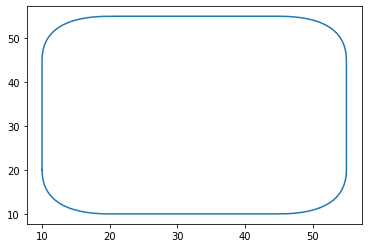

In [ ]:
#Unit testing of the trajectory module
traj_1 = [
  (10,20,10,45),
  (10,45,10,55,20,55),
  (20,55,45,55),
  (45,55,55,55,55,45),
  (55,45,55,20),
  (55,20, 55,10, 45, 10),
  (45,10, 20,10),
  (20,10, 10,10, 10,20 )
]
myTraj = Trajectory(traj_1)
myTrajPoints = myTraj.getPoints()

plt.plot(myTrajPoints[:,0],myTrajPoints[:,1])
#print(myTraj.length)
for loc in np.linspace(0,1.0,num=101):
  p,a = myTraj.getTrajPose(loc)
  #print(p,a/math.pi*180)

print(myTraj.getTrajMerge(55,54))

In [ ]:

class Rat:
  '''Rat is a differential drive robot (two wheels). Random wheel slippage is implemented'''
  def __init__ (
      self,
      # initial pose
      x0 = 10,          
      y0 = 10,
      theta0 = 0,
      speed = 1, #nominal speed 
      wheelBase = 5, #in units of grid cells
      slipParam = SLIP_PARAM, #paramter for power law distribution for wheel slip
      angStdDev = PRED_ANG_STD_ERR, #std dev for heading noise
      randSeedL = 0, #seed for random number generator for left wheel
      randSeedR = 10, #seed for random number generator for right wheel
      randSeedT = 20, #seed for random number generator for angle
      randSeedM = 30, #seed for random number generator for measurement
      numScanAngles = 72, #number of scan angles for onboard range finder
  ):
    #Current pose
    self.x = x0
    self.y = y0
    self.theta = theta0

    #initial velocities
    self.speed = speed
    self.v = speed #speed along the trajectory
    self.w = 0 #instantaneous angular velocity

    #odometers
    self.leftO = 0
    self.rightO = 0
    #estimated pose
    self.xEst = x0
    self.yEst = y0
    self.thetaEst = theta0

    #vehicle and environment parameters
    self.WHEELBASE = wheelBase
    self.SLIPPARAM = slipParam
    self.ANGSTDDEV = angStdDev
    self.EMPTY_COLOR = 128 #color of empty cell
    self.MEASURE_RANGE = MEASURE_RANGE #grid units
    self.RANGE_ERROR = RANGE_ERROR #grid unit of error for range measurement
    self.COLOR_ERROR = COLOR_ERROR #error in pixel's color value 
    self.RANGE_NOISE_RANDOM = RANGE_NOISE_RANDOM #probability of uniform random noise versus fixed noise in range measurement ver

    self.rng_l = np.random.default_rng(randSeedL)
    self.rng_r = np.random.default_rng(randSeedR)
    self.rng_t = np.random.default_rng(randSeedT)
    self.rng_m = np.random.default_rng(randSeedM)

    #random generators for the sampleMotionModel for prediction
    self.rngEst_l = np.random.default_rng(randSeedL)
    self.rngEst_r = np.random.default_rng(randSeedR)
    self.rngEst_t = np.random.default_rng(randSeedT)

    self.numScanAngles = numScanAngles
    self.dist = np.zeros(numScanAngles)
    self.color = np.zeros(numScanAngles)
    self.angle = np.zeros(numScanAngles)

    #print(self.WHEELBASE)

  def move (
      self,
      tstep, #timestep
  ):
    '''Implement noisy motion. Noise happens due to wheel slippages'''

    #calculate the desired velocities of the left and right wheel
    vl = self.v - 0.5*self.WHEELBASE*self.w
    vr = self.v + 0.5*self.WHEELBASE*self.w

    #update odometers
    self.leftO += vl*tstep
    self.rightO += vr*tstep 

    #sample left and right wheel slippage
    #from power law distribution
    #modeling probablity no slip: mostly no slip - occasional slip as as per 
    #pdf of power law pdf(x) a*x^(a-1) for x in [0,1] and a >= 1
    sr = self.rng_r.power(self.SLIPPARAM)
    sl = self.rng_l.power(self.SLIPPARAM)
    #model angular noise a gaussian
    nt = self.rng_t.normal(0,self.ANGSTDDEV)

    #incorporate the wheel slippage to get actual wheel linear velocities which will be smaller
    vla = vl*sl
    vra = vr*sr

    #vla = self.rng_l.normal(vl,PRED_VEL_STD_ERR)
    #vra = self.rng_r.normal(vr,PRED_VEL_STD_ERR)
    

    #regenerate the noise velocities
    vn = (vla+vra)/2
    wn = (vra-vla)/self.WHEELBASE
    phi = math.copysign(1,vn)*wn * tstep

    #update the pose after the timestep
    if ( abs(vla-vra)>0.01*min(abs(vla),abs(vra))):  #has some rotation
      R = abs(vn)/wn
      self.x = self.x - R*math.sin(self.theta) + R*math.sin(self.theta+phi)
      self.y = self.y + R*math.cos(self.theta) - R*math.cos(self.theta+phi)
      self.theta = self.theta + phi
    else:  #no rotation
      self.x = self.x + (vla+vra)*0.5*tstep*math.cos(self.theta)
      self.y = self.y + (vla+vra)*0.5*tstep*math.sin(self.theta)

    #now add the extra noise to angle
    self.theta = self.theta + nt 

    #keep theta within +- math.pi
    if ( self.theta >= math.pi):
      self.theta += -2*math.pi
    if (self.theta <= -math.pi):
      self.theta += 2*math.pi


  def sampleMotionModel (
      self,
      v,
      w,
      pose,
      velStdErr=0.1,
      angStdErr=math.pi*0.01,
      tstep=1  
  ) :

    xEst, yEst, thetaEst = pose[0],pose[1],pose[2]  
    #assume wheel velocity noise is gaussian and independent
    #calculate the desired velocities of the left and right wheel
    vl = v - 0.5*self.WHEELBASE*w
    vr = v + 0.5*self.WHEELBASE*w

    #sample left and right wheel slippage
    #from power law distribution
    #vra = self.rngEst_r.normal(vr,velStdErr)
    #vla = self.rngEst_l.normal(vl,velStdErr)
    vra = vr*self.rngEst_r.power(SLIP_PARAM)
    vla = vl*self.rngEst_l.power(SLIP_PARAM)
    #model angular noise a gaussian
    nt = self.rngEst_t.normal(0,angStdErr)

    #regenerate the noise velocities
    vn = (vla+vra)/2
    wn = (vra-vla)/self.WHEELBASE
    phi = math.copysign(1,vn)*wn * tstep

    #update the pose after the timestep
#    if ( abs(vla-vra)>0.01*min(abs(vla),abs(vra))):  #has some rotation
    if ( abs(wn)>0):  #has some rotation
      R = abs(vn)/wn
      xn = xEst - R*math.sin(thetaEst) + R*math.sin(thetaEst+phi)
      yn = yEst + R*math.cos(thetaEst) - R*math.cos(thetaEst+phi)
      thetan = thetaEst + phi
    else:  #no rotation
      xn = xEst + (vla+vra)*0.5*tstep*math.cos(thetaEst)
      yn = yEst + (vla+vra)*0.5*tstep*math.sin(thetaEst)
      thetan = thetaEst

    #now add the extra noise to angle
    thetan = thetan + nt 

    #keep theta within +- math.pi
    if ( thetan >= math.pi):
      thetan += -2*math.pi
    if (thetan <= -math.pi):
      thetan += 2*math.pi

    return xn, yn, thetan


  def initPose (
    self,
    x0,
    y0,
    theta0  
  ) :
    #Current pose
    self.x = x0
    self.y = y0
    self.theta = theta0
    #odometers
    self.leftO = 0
    self.rightO = 0
    #estimated pose
    self.xEst = x0
    self.yEst = y0
    self.thetaEst = theta0


  def getTruePose (
      self
  ):
    #for plotting ground truth
    return(self.x, self.y, self.theta)

  def setTraj (
      self,
      traj, 
      trajStartLoc=0
  ):
    self.traj = traj
    self.trajLoc = trajStartLoc
    p, self.theta = traj.getTrajPose(self.trajLoc)
    self.x = p[0]
    self.y = p[1]

      
  def trajFollowStep(
      self,
      traj,
      tstep,
  ):
    #calculate the angular velocity for the next time step based 
    #merging with the actual trajectory at the nearest point
    #next heading
    a = traj.getTrajMerge(self.x, self.y)
    #assume that the points are close and only adjust the angular velocity
    self.w = (a-self.theta)/tstep
    if DEBUG_RAT:
      print("Rat.trajFollowStep: heading change=",(a-self.theta)*180/math.pi,"self.w",self.w)
    self.move(tstep)

  def measureBeam(
      self,
      mi, #map
      bearing, #radians: angle of range finder beam
      isAngleRelative = True # If true, bearing is relative to robot pose else w.r.t ground truth
  ):
    #returns coordinate of obstacle (or infinity if none) and color
    
    if isAngleRelative :
      absoluteBearing = bearing + self.theta
    else :
      absoluteBearing = bearing

    a=absoluteBearing
    if (abs(math.cos(a)) < 0.7) :
        rStep = GRID_SIZE/abs(math.sin(a))
    else:
        rStep = GRID_SIZE/abs(math.cos(a))  

    dx = rStep*math.cos(absoluteBearing)
    dy = rStep*math.sin(absoluteBearing)

    rn1 = math.inf
    color = EMPTY_COLOR
    rn_r = 0.0
    for i in range(1,int(self.MEASURE_RANGE/rStep)):
      x, y = int(self.x + i*dx), int(self.y+i*dy)
      rn_r += rStep
      #print("measureBeam:x,y=",x,y)
      if ( (x < 0) or (y < 0) or (x >= MAP_X) or (y >= MAP_Y)) : 
        #exceeding the limits
        break
      if (mi.map[x,y] != EMPTY_COLOR) :
        #return a reflection adding noise
        rn_n=self.rng_m.normal(0,self.RANGE_ERROR) #small range noise
        #rn_r = math.sqrt((x-self.x)**2 + (y-self.y)**2)
        rn1 = rn_n + rn_r
        color =  mi.map[x,y] + self.rng_m.normal(0, self.COLOR_ERROR) #noise to add to color
        break

    rn2=self.rng_m.uniform(1,self.MEASURE_RANGE) #completely random noise
    #randomly choose between the two
    rn = self.rng_m.choice([rn1,rn2],p=[1-self.RANGE_NOISE_RANDOM, self.RANGE_NOISE_RANDOM])
    if (DEBUG_MEASURE):
      print("measureBeam: rn1,rn2,rn, absoluteAngle",rn1,rn2,rn,absoluteBearing)
    if color < EMPTY_COLOR :
      color = 0
    return rn, int(color)

  def scan (
      self,
      realMap,
      numScanAngles=72
  ):
    j=0
    for b in np.arange (-math.pi, math.pi, math.pi*2/numScanAngles):
      self.dist[j],self.color[j] = self.measureBeam(realMap,b)
      self.angle[j] = b
      j += 1
    return self.dist, self.angle, self.color
   #end scan

#end of MyRat

In [ ]:
#Utility Functions
def rmsPoseErr (
    x, y
) :
  return math.sqrt ((x[0]-y[0])**2 + (x[1]-y[1])**2 + (x[2]-y[2])**2)

def move(
        p, #current pose as x,y, theta
        pdot, #pose change as v, w, delta_theta
        tstep=1, #timestep
  ):
    '''Implement 2D motion. Returns new pose to be  p + f[pdot] * t'''

    v, w, dt = pdot
    x,y, theta = p

    #phi = math.copysign(1,v)*w * tstep
    phi = w * tstep

    thetan = theta + phi
    

    xn = x + v*tstep*math.cos(thetan)
    yn = y + v*tstep*math.sin(thetan)

    #now add the extra noise to angle
    thetan += dt 

    #keep theta within +- math.pi
    if ( thetan >= math.pi):
        thetan += -2*math.pi
    if (thetan <= -math.pi):
        thetan +=  2*math.pi
    
    return [xn,yn,thetan]
#end move

def addVelNoise (
        pdot, #v, w, theta
        rng,  #noise gen
        v_std, #wheel velocity noise std. err
        a_std, #angle noise std err
        base, #separation of wheels for a 2-wheeled robot
        ):
    ''' add noise to linear and angular velocities for a differential drive robot'''
    
    v,w,t = pdot
    vl = v - 0.5*base*w
    vr = v + 0.5*base*w

    #sample left and right wheel slippage
    vra = rng.normal(vr,v_std)
    vla = rng.normal(vl,v_std)
    #model angular noise a gaussian
    tn = rng.normal(0,a_std)

    #regenerate the noise velocities
    vn = (vla+vra)/2
    wn = (vra-vla)/base    
    
    return vn,wn,tn
    
#end addVelNoise
#%%
def estPoseMap (
    particlePose,
    particleWt,
):
  estPose = np.average(particlePose,0,particleWt)
  #particle with largest weight (maximum likelihood)
  mle = np.argmax(particleWt)
  estMap = particleMap[mle]
  return estPose, estMap

def plotMap (
#        m,      #MAP2D object
#        p,      #pose
        idx
        ):
    m  = particleMap[idx]
    p = particlePose[idx]
    layout = np.zeros((m.size_x, m.size_y))+EMPTY_COLOR
    for i in range (m.size_x):
      for  j in range(m.size_y):
        if m.logOdds[i,j] > 0 :   #filled for sure, p > 0.9
          layout[i,j] = m.map[i,j]  #show the current value
        else:                      #empty for sure, p < 0.1                                            
          layout[i,j] = EMPTY_COLOR
    
    layout[int(p[0]),int(p[1])] = 100  #indicate the pose with violet color
    plt.imshow(layout.T,cmap="seismic",vmin=0,vmax=255, origin="lower")
    plt.colorbar(cmap="seismic")
    plt.show()    
#end plotMap
#%%
def plotMapM (
        m,      #MAP2D object
        p,      #pos
        ):

    layout = np.zeros((m.size_x, m.size_y))+EMPTY_COLOR
    for i in range (m.size_x):
      for  j in range(m.size_y):
        if m.logOdds[i,j] > 0 :   #filled for sure, p > 0.9
          layout[i,j] = m.map[i,j]  #show the current value
        else:                      #empty for sure, p < 0.1                                            
          layout[i,j] = EMPTY_COLOR
    
    layout[int(p[0]),int(p[1])] = 100  #indicate the pose with violet color
    plt.imshow(layout.T,cmap="seismic",vmin=0,vmax=255, origin="lower")
    plt.colorbar(cmap="seismic")
    plt.show()    
#end plotMapM
#%%

def updateHist(
        p,                #[0]:rx, [1]: ry, [1]: theta: pose of the scanner
        dist,             #distance measured by beam
        color,            #color
        angle,            #angle of beam
        mHist,            #occupancy count
        cHist             #latest color
        ):
#update histogram with the measured data
    rx,ry,theta = p[0], p[1], p[2]
    for i in range(dist.shape[0]):
        d= dist[i]
        a= angle[i] + theta
        c = color[i]
        if (abs(math.cos(a)) < 0.7) :
            rStep = GRID_SIZE/abs(math.sin(a))
        else:
            rStep = GRID_SIZE/abs(math.cos(a))  
        if (d != math.inf ) : # a valid measurement     
            zx = int(rx + math.ceil(d/rStep)*rStep*math.cos(a))
            zy = int(ry + math.ceil(d/rStep)*rStep*math.sin(a))
            mHist[zx,zy] += 1
            cHist[zx,zy] = c
    #end for i    
#end updateHist


def runScan (
        nStep,     #number of steps to run
        idx = 0    #index of particle
        ):

    for i in range(nStep):
        #SENSE
        #do a 360 scan at beam step of 5 degrees.
        dist, color, angle = myRat.scan(realMap)
        #updateHist(myRat.getTruePose(),dist,color,angle,mHist,cHist)
        particleLogWt[idx] += occUpdate_new(particleMap[idx], dist,angle,color, particlePose[idx][0], particlePose[idx][1], particlePose[idx][2],RANGE_ERROR, COLOR_ERROR)
        
#end runScan
#%%
def viewMeas(rnArr,angleArr, zcArr,pose):
    #convert the measurements into grid locations for easy debugging
    rx,ry,theta = pose[0],pose[1],pose[2]
    for j in range(rnArr.shape[0]): #sweep through all the angles  
      rn = rnArr[j]
      angle = angleArr[j] + theta
      zc = zcArr[j] 
      #get the right step size to use to scan along an angle, so that
      # we fall into a grid cell at most once (for diagonal beams need
      # to increase step seize)

      #determine the  coordinate of the grid cell corresponding to the range
      #measurement  
      if (rn != math.inf ) : # a valid measurement     
        zx = int(rx + rn*math.cos(angle))
        zy = int(ry + rn*math.sin(angle))
        print("[",zx,",",zy,"]=",zc)
      #end if    
    
#end viewMeas
#%%
def plotMeas(rnArr,zcArr,angleArr,pose):
    #convert the measurements into a plot for easy debugging
    rx,ry,theta = pose[0],pose[1],pose[2]
    layout = np.zeros((MAP_X,MAP_Y))+EMPTY_COLOR

    for j in range(rnArr.shape[0]): #sweep through all the angles  
      rn = rnArr[j]
      angle = angleArr[j] + theta
      zc = zcArr[j] 
      #get the right step size to use to scan along an angle, so that
      # we fall into a grid cell at most once (for diagonal beams need
      # to increase step seize)

      #determine the  coordinate of the grid cell corresponding to the range
      #measurement  
      if (rn != math.inf ) : # a valid measurement     
        zx = int(rx + rn*math.cos(angle))
        zy = int(ry + rn*math.sin(angle))
        layout[zx,zy] = zc
 #       print("[",zx,",",zy,"]=",zc)
      #end if       
    layout[int(rx),int(ry)] = 100  #indicate the pose with violet color
    plt.imshow(layout.T,cmap="seismic",vmin=0,vmax=255, origin="lower")
    plt.colorbar(cmap="seismic")
    plt.show()       
#end plotMeas
#%%

def psort(targetPose, particlePose):
    '''return the index of particles with increasing distance of pose'''
    return np.argsort(np.sum((particlePose-targetPose)**2,axis=1))
#end psort
#%%
def in_hull(points, x):
    n_points = len(points)
    c = np.zeros(n_points)
    A = np.r_[points.T,np.ones((1,n_points))]
    b = np.r_[x, np.ones(1)]
    lp = linprog(c, A_eq=A, b_eq=b)
    return lp.success


In [ ]:
def sampleImportanceResample (
    particlePose,
    particleMap,
    particleLogWt,
    particleWt,
    rngSir,
    epp,
    pLogWtHist,
):
  '''Sample Importance Resampling'''
  NPARTICLES = particlePose.shape[0]
  newParticlePose = np.zeros((NPARTICLES,3)) #particles for pose estimate
  newParticleMap = []
  nEpp = np.zeros((NPARTICLES,NSTEPS,3))
  npHist = np.zeros((NPARTICLES, NSTEPS))

  q = rngSir.random()*1.0/NPARTICLES
  c = particleWt[0]
  k = 0
  for j in range(NPARTICLES):
    U = q+j/NPARTICLES
    while U > c :
      k = k + 1
      c = c + particleWt[k]
    newParticlePose[j] = particlePose[k]
    newParticleMap.append(copy.deepcopy(particleMap[k]))
    particleLogWt[j] = 0
    #particleLogWt[j] = particleLogWt[k]
    nEpp[j] = epp[k]
    npHist[j] = pLogWtHist[k]


  return newParticlePose, newParticleMap, particleLogWt, nEpp,npHist

In [ ]:
#Likelihood calculation
def getLogLkl (
      map2D,    #map is an object of class Map2D that needs to be updated
      rnArr,    #array of range locations of each scan hit
      angleArr, #array of angles for each scan
      zcArr,    #array of observed color value at each scan
      pose,     #x,y,theta of the robot/particle
      locStd,   #std dev of error for range measurement
      colStd,   #std dev of error for color measurement
      ptm=0.9,  #probability of true measurement
      pfn=0.05, #probability of false negative     
      pfp=0.05, #probability of false positive
  ):
    '''
      return log likelihood for this measurement.
    '''
    theta = pose[2]
    logLkl = 0 #log likelihood
    logLklArr = np.zeros(rnArr.shape[0])
    for j in range(rnArr.shape[0]): #sweep through all the angles  
      rn = rnArr[j]
      angle = angleArr[j] + theta
      rpose = [pose[0],pose[1],angle]
      zc = zcArr[j] 
      logLklArr[j] = getLogLklBeam (map2D, rn, angle, zc, rpose, locStd, colStd, ptm,pfn,pfp)
      logLkl += logLklArr[j]
    #end for j
    return logLkl
#end getLogLkl

#%%
def getLogLklBeam (
      map2D,    #map is an object of class Map2D that needs to be updated
      rn,    #range location of  hit for this beam
      angle, #absolute angle for the scan beam
      zc,    #array of observed color value at this beam
      pose,  #x,y,theta of robot/particle
      locStd,   #std dev of error for range measurement
      colStd,   #std dev of error for color measurement
      ptm=0.9,  #probability of true measurement
      pfn=0.05, #probability of false negative     
      pfp=0.05, #probability of false positive
  ):
    '''
      return log likelihood for this measurement.
    '''

    rx,ry = pose[0],pose[1]
    
    logLkl = 0 #log likelihood
    #get the right step size to use to scan along an angle, so that
    # we fall into a grid cell at most once (for diagonal beams need
    # to increase step size)
    if (abs(math.cos(angle)) < 0.7) :
        rStep = GRID_SIZE/abs(math.sin(angle))
    else:
        rStep = GRID_SIZE/abs(math.cos(angle))     

    #determine the  coordinate of the grid cell corresponding to the range
    #measurement  
    lim = math.ceil(MEASURE_RANGE/rStep) 
    
    pz = 1.0 #holds the probability of all empty cells along the beam upto hit cell
    for i in range(0,lim+1):
        sx = int(rx + i*rStep * math.cos(angle))
        sy = int(ry + i*rStep * math.sin(angle))
        withinMap = sx > 0 and sx < MAP_X and sy > 0 and sy < MAP_Y

        if i*rStep < rn and withinMap : #upto hit cell consider all empty cells          
            if (map2D.logOdds[sx,sy] < -5) : # log odds of occupancy is too low
                po = 0
            else:
                po = 1.0/(1.0+math.exp(-map2D.logOdds[sx,sy]))
            pz = pz*(1-po)
        else:
            break
    #end for i
    if pz > 0 :
        logLkl += math.log(pz)
    else:
        logLkl += -10
    #end for j
    if (rn != math.inf ) : #consider the actual hit value 
        #coordinates of the hit cell
        zx = int(rx + rn*math.cos(angle))
        zy = int(ry + rn*math.sin(angle))
        hitCellInMap = zx > 0 and zx < MAP_X and zy > 0 and zy < MAP_Y
        if not hitCellInMap : #something wrong kill this particle
            logLkl -= 100
            return logLkl
        #calculate prob of explaining the measurement by searching
        #in the neighbourhood of 3x3 grid cells around the hit cell
        pz = 0   #this is the probability of explaining this measurement
        for u in [-1,0,1]:
            ux = zx+ u            
            for v in [-1, 0, 1]:
                vy = zy + v
                d = max(abs(u), abs(v)) #distance from center cell
                if ux > 0 and ux < MAP_X and vy > 0 and vy < MAP_Y : #within map
                    if (map2D.logOdds[ux,vy] < -5) : # log odds of occupancy is too low
                        po = 0
                    else:
                        po = 1.0/(1.0+math.exp(-map2D.logOdds[ux,vy]))
                    po = po * 0.9* math.exp(-d/2/locStd**2)
                    if map2D.count[ux, vy] > 0: #cell had a hit, include color error
                        po = po * 0.9* math.exp(-(zc-map2D.map[ux,vy])**2/2/colStd**2) #0.9 is a scale factor
                    pz += po  #po = prob of occupancy x prob of location shift x prob of color shift
              #end for v
        #end for u
        if pz > 0 :
            logLkl += math.log(pz)
        else:
            logLkl += -10
    return logLkl
#end getLogLklBeam

In [ ]:
#Grid Occupancy Update
def occUpdate(
      map2D,    #map is an object of class Map2D that needs to be updated
      rnArr,    #array of range locations of each scan hit
      angleArr, #array of angles for each scan
      zcArr,    #array of observed color value at each scan
      pose,     #x,y,theta of robot/particle
      locStd,   #std dev of error for range measurement
      colStd,   #std dev of error for color measurement
      ptm=0.9,  #probability of true measurement
      pfn=0.05, #probability of false negative     
      pfp=0.05, #probability of false positive
  ):
    '''
      Update cell log odds based on measured data
    '''

    rx,ry,theta = pose[0],pose[1],pose[2]

    for j in range(rnArr.shape[0]): #sweep through all the angles  
      rn = rnArr[j]
      angle = angleArr[j] + theta
      zc = zcArr[j] 
      #get the right step size to use to scan along an angle, so that
      # we fall into a grid cell at most once (for diagonal beams need
      # to increase step seize)
      if (abs(math.cos(angle)) < 0.7) :
        rStep = GRID_SIZE/abs(math.sin(angle))
      else:
        rStep = GRID_SIZE/abs(math.cos(angle))     

      #determine the  coordinate of the grid cell corresponding to the range
      #measurement  
      hitCellInMap = False
      lim = int(MEASURE_RANGE/rStep)
      zx,zy = MAP_X, MAP_Y
      if (rn != math.inf ) : # a hit measurement    
          #coordinates of the hit cell
          zx = int(rx + rn*math.cos(angle))
          zy = int(ry + rn*math.sin(angle))
          hitCellInMap = zx > 0 and zx < MAP_X and zy > 0 and zy < MAP_Y
          lim = int(rn/rStep) 
      #end if rn !=
      #now update the occupancy probabilities      
      for i in range(0,lim+1): #upto the hit cell
        sx = int(rx + i*rStep * math.cos(angle))
        sy = int(ry + i*rStep * math.sin(angle))
        withinMap = sx > 0 and sx < MAP_X and sy > 0 and sy < MAP_Y
        if withinMap  : #within map
            if ( sx != zx and sy != zy ) : #Confirm no the hit cell
                if pfn > 0 :
                    map2D.logOdds[sx,sy] += math.log(pfn/ptm)
                else:
                    map2D.logOdds[sx,sy] += -1
            else: #at hit cell
                break
        else: #outside map
            break
        #end if not (sx < ....)  
      #end for i

      #update hit cell
      if hitCellInMap :
         cTarget = map2D.map[zx,zy] #existing color
         if pfp > 0 :
              map2D.logOdds[zx,zy] += math.log(ptm/pfp)
         else:
              map2D.logOdds[zx,zy] += 1.0
         a = map2D.count[zx,zy]/(map2D.count[zx,zy]+1)              
         map2D.count[zx,zy] += 1
         if  cTarget != EMPTY_COLOR and cTarget != FILL_COLOR and zc != FILL_COLOR and zc != EMPTY_COLOR:
             #average the existing color with new one
             if zc != FILL_COLOR and zc != EMPTY_COLOR : #
                 map2D.map[zx,zy] = a*cTarget + (1-a)*zc #filter with observed color 
         elif map2D.logOdds[zx,zy] < 3 and map2D.logOdds[zx,zy] > -3:  #likely empty cell - replace existing with observed color
             map2D.map[zx,zy] = zc              
    #end for j
#end occUpdate

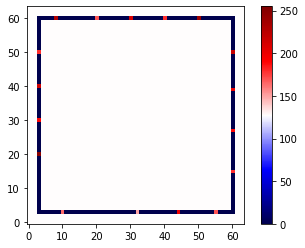

In [ ]:
#%%  Create Map
# Create the real Map with 8 nest features 
realMap = Map2D(MAP_X,MAP_Y)
#list of walls in x1,y1 to x2,y2
nestLayout = [(3,3,3,60),
            (3,60,60,60),
            (60,60,60,3),
            (3,3,60,3),
            ]

#list of features as x,y, color
nestFeatures = [(3,20,250),
                (3,30, 190),
                (3,40,215),
                (3,50,180),
              (8,60,230),
              (20,60,170),
              (30,60,210),
              (40,60,180),
              (50,60,240),
              (60,50,220),
              (60,39,200),
              (60,27,190),
              (60,15,180),
              (55,3,170),
              (44,3,200),
              (32,3,150),
              (10,3,165)
              ]
realMap.buildMap(nestLayout, nestFeatures)

# Create a trajectory for the rat to follow
ratTraj_nodes = [
#  (10,20,10,30,20,30),
#  (20,30,30,30,30,20),
#  (30,20,30,10,20,10),
#  (20,10, 10,10, 10,20 ),
  (10,20,10,45),
  (10,45,10,55,20,55),
  (20,55,45,55),
  (45,55,55,55,55,45),
  (55,45,55,20),
  (55,20, 55,10, 45, 10),
  (45,10, 20,10),
  (20,10, 10,10, 10,20 )
]
ratTraj = Trajectory(ratTraj_nodes)
ratTrajPoints = ratTraj.getPoints(1)
plt.imshow(realMap.getLayout(),cmap="seismic",vmin=0,vmax=255, origin="lower")
plt.colorbar(cmap="seismic")
plt.show()

True Pose: 14.768752843303748 52.57685118081467 0.4456588050518218
particle Estimated Pose [13.0050471  50.62874072  0.43370442]


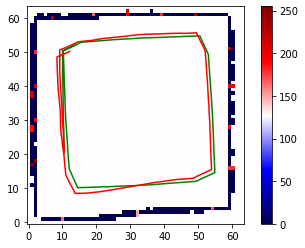

In [ ]:
NSTEPS = 200
NPARTICLES = 40

NUM_ANGLES = 72 #number of angles to scan for each measurement

#DEBUG FLAGS
DEBUG_OCC = False
DEBUG_TB = False
DEBUG_RAT_SAMPLE_MOTION = False
DEBUG_RAT = False
DEBUG_MEASURE=False

#Instantiate my rat
myRat = Rat(slipParam=10,  #param for power law for slip probability
            angStdDev=math.pi*0.001, #std dev for noise in angle
            randSeedL=100, 
            randSeedR=10, 
            randSeedT=35,
            numScanAngles=NUM_ANGLES)

mHist = np.zeros((MAP_X,MAP_Y))
cHist = np.zeros((MAP_X,MAP_Y))

myRat.initPose(10.5,20.5,math.pi/2)

tp = np.zeros((NSTEPS,3)) #true pose
tpLogWtHist = np.zeros(NSTEPS) #time history of log likelihood for true particle
tp[0] = myRat.getTruePose()
#true particle for debugging purposes
tpMap = Map2D(MAP_X,MAP_Y)
tpLogWt = 0

#%%
ep = np.zeros((NSTEPS,3)) #estimated average pose
poseErr = np.zeros(NSTEPS)  #average pose error with time
lklErr = np.zeros(NSTEPS)  #likelihood error with time

ep[0] = myRat.getTruePose()

rng_mov = np.random.default_rng(20)  #for random motion of rat
rng_par = np.random.default_rng(22) #for sampling particle motion
rngSir = np.random.default_rng(122)

epp = np.zeros((NPARTICLES, NSTEPS, 3)) #estimated per particle pose
for i in range(NPARTICLES):
  epp[i][0] = myRat.getTruePose()


particlePose = np.zeros((NPARTICLES,3)) #particles for pose estimate
particleLogWt = np.zeros(NPARTICLES) #keep weights as log likelihoods
pLogWtHist = np.zeros((NPARTICLES,NSTEPS))  #time history of log likelihoods for each particle
particleWt = np.zeros(NPARTICLES) #actual weights
particleMap = []
#print("i:",0,"\nTrue Pose=",tp[0])



#initialize the particles
for i in range(NPARTICLES):
  particleMap.append(Map2D(MAP_X,MAP_Y))
  particlePose[i] = myRat.getTruePose()
  #print("Particle[",i,"].pose=",particlePose[i])


for i in range(1,NSTEPS):

  #PREDICT
  v = 1  #constant speed
  #find the new heading to merge with desired trajectory
  w = (ratTraj.getTrajMerge(tp[i-1,0],tp[i-1,1]) - myRat.theta)/TSTEP
  #add motion noise 
  vn,wn,tn = addVelNoise([v,w,0],rng_mov, v_std=MOV_V_STD_ERR, a_std=MOV_A_STD_ERR, base=WHEELBASE)

  #move the robot
  myRat.x, myRat.y, myRat.theta = move(tp[i-1],[vn,wn,tn],TSTEP)
  #myRat.trajFollowStep(ratTraj,TSTEP) #Take a step 
  tp[i] = myRat.getTruePose()         #get true pose only for plotting

  #SENSE
  #do a 360 scan at beam step of 5 degrees.
  dist, angle, color = myRat.scan(realMap)
  #updateHist(myRat.getTruePose(),dist,color,angle,mHist,cHist)

  #PARTICLE UPDATE
  #for debugging purposes - generate a bunch of particle poses directly from true pose
  #particlePose = np.random.normal([myRat.x, myRat.y,myRat.theta],[0.1,0.1,0.01],(NPARTICLES,3))

  #move each particle randomly by sampling motion model
  for j in range(NPARTICLES):
    pvn,pwn,ptn = addVelNoise([v,w,0],rng_par, v_std=PAR_V_STD_ERR, a_std=PAR_A_STD_ERR, base=WHEELBASE)
    particlePose[j] = move(particlePose[j],[pvn,pwn,ptn], TSTEP) 
   
  #check if the robot  is in hull of particles (for debugging only)
  #if not in_hull(particlePose,tp[i]) :
  #    print (i, ":robot not in particle hull anymore!")
      
  
  for j in range(NPARTICLES) :
    pLogWtHist[j][i] = getLogLkl(particleMap[j], dist,angle,color, particlePose[j],RANGE_ERROR, COLOR_ERROR)
    #pLogWtHist[j][i] = -1000*np.sum((tp[i]-particlePose[j])**2)   #just for debugging purpose
    particleLogWt[j] += pLogWtHist[j][i]
    epp[j][i] = particlePose[j]

  tpLogWtHist[i]=getLogLkl(tpMap, dist,angle,color,tp[i],RANGE_ERROR, COLOR_ERROR)
  tpLogWt += tpLogWtHist[i]

    
  for j in range(NPARTICLES):
    occUpdate(particleMap[j], dist,angle,color, particlePose[j],RANGE_ERROR, COLOR_ERROR)
    
    #epp[j][i] = particlePose[j]
  #end for j

  #update for true particle - only for debugging
  occUpdate(tpMap, dist,angle,color, tp[i],RANGE_ERROR, COLOR_ERROR)



  tpLogWt = tpLogWt - np.max(particleLogWt)
  particleLogWt = particleLogWt - np.max(particleLogWt)  
  particleWt = np.exp(particleLogWt)
  particleWt = particleWt/np.sum(particleWt)
  mle = np.argmax(particleWt)
  #keep track of the estimated pose as a function of time
# ep[i] =   particlePose[mle]
  poseErr[i] = np.sum((tp[i] - epp[mle][i])**2)
  lklErr[i] = tpLogWtHist[i] - pLogWtHist[mle,i]

  #RESAMPLE: Sampling Importance Resampling
  particlePose, particleMap, particleLogWt, epp, pLogWtHist = sampleImportanceResample (particlePose, particleMap,particleLogWt,particleWt,rngSir, epp, pLogWtHist)

 
#end for i

estPose, estMap = estPoseMap(particlePose, particleWt)
ep = epp[mle]


print("True Pose:",myRat.x,myRat.y,myRat.theta)
print("particle Estimated Pose",estPose)
#print("particle weigts",particleWt)
ratTrajPoints = ratTraj.getPoints(1)

#plt.plot(ratTrajPoints[:,0],ratTrajPoints[:,1], "blue")  
#time slice for plotting
ts = -300
tf = -1

plt.plot(tp[ts:tf,0],tp[ts:tf,1],"green") #plot last few points
plt.plot(ep[ts:tf,0],ep[ts:tf,1],"red") #plot last few points
plt.imshow(estMap.getLayout(),cmap="seismic",vmin=0,vmax=255, origin="lower")
plt.colorbar(cmap="seismic")
plt.show()
